In [ ]:
#!pip install --upgrade matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.colors as mcolors
import matplotlib.cm as cm  # Correct import for ScalarMappable

In [ ]:
# 1. Loading and preprocessing the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
x_test = x_test.astype('float32') / 255.0
# Adding a channel dimension for grayscale images (required by Conv2D)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# 2. Building and training the Convolutional Neural Network (CNN)
input_layer = Input(shape=(28, 28, 1))

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', name='conv_layer_1')(input_layer)
x = MaxPooling2D((2, 2), name='maxpool_layer_1')(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv_layer_2')(x)
x = MaxPooling2D((2, 2), name='maxpool_layer_2')(x)

# Dense (fully connected) layers
x = Flatten(name='flatten_layer')(x)
x = Dense(64, activation='relu', name='dense_layer')(x)
output_layer = Dense(10, activation='softmax', name='output_layer')(x)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8394 - loss: 0.5500 - val_accuracy: 0.9800 - val_loss: 0.0630
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9788 - loss: 0.0684 - val_accuracy: 0.9869 - val_loss: 0.0412
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9874 - loss: 0.0418 - val_accuracy: 0.9870 - val_loss: 0.0410
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9884 - loss: 0.0365 - val_accuracy: 0.9894 - val_loss: 0.0320
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9918 - loss: 0.0267 - val_accuracy: 0.9905 - val_loss: 0.0276


In [ ]:
# 3. Create a fixed color map for digits 0-9
# Use a fixed colormap where each number gets the same color across plots
colors = plt.get_cmap('tab10')  # Tab10 has 10 distinct colors
color_map = {i: colors(i) for i in range(10)}  # Map digits to colors

# Create a normalization object to scale label values between 0 and 9
norm = mcolors.Normalize(vmin=0, vmax=9)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


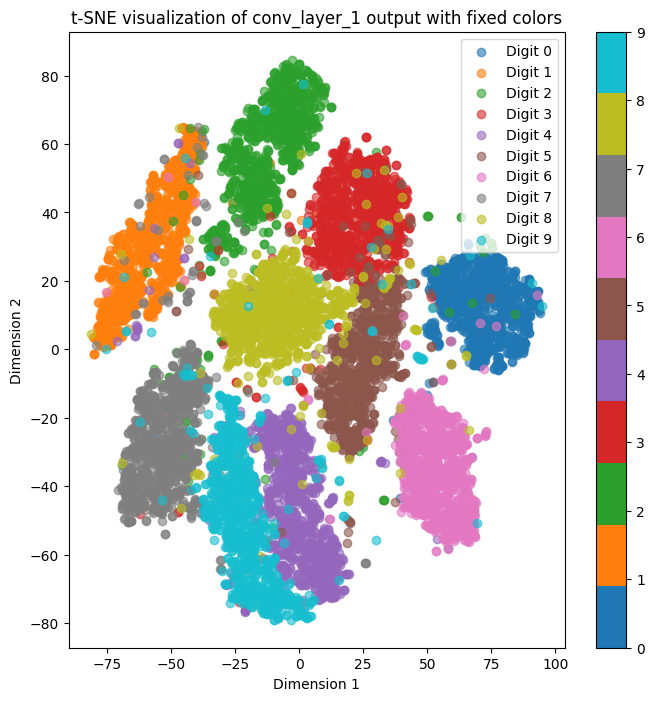

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


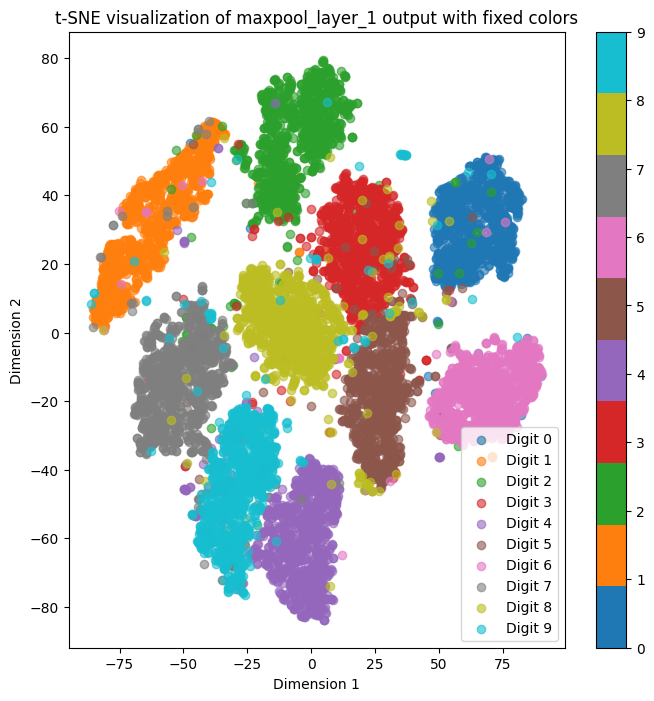

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


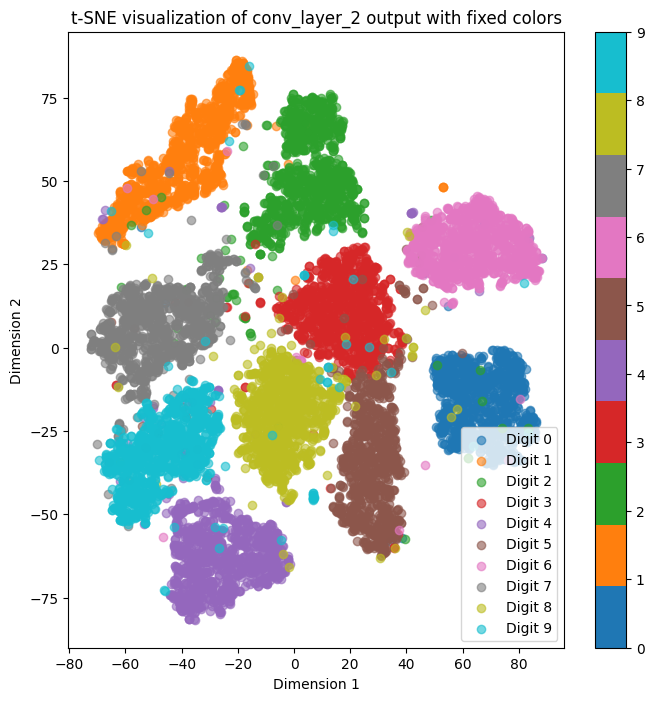

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


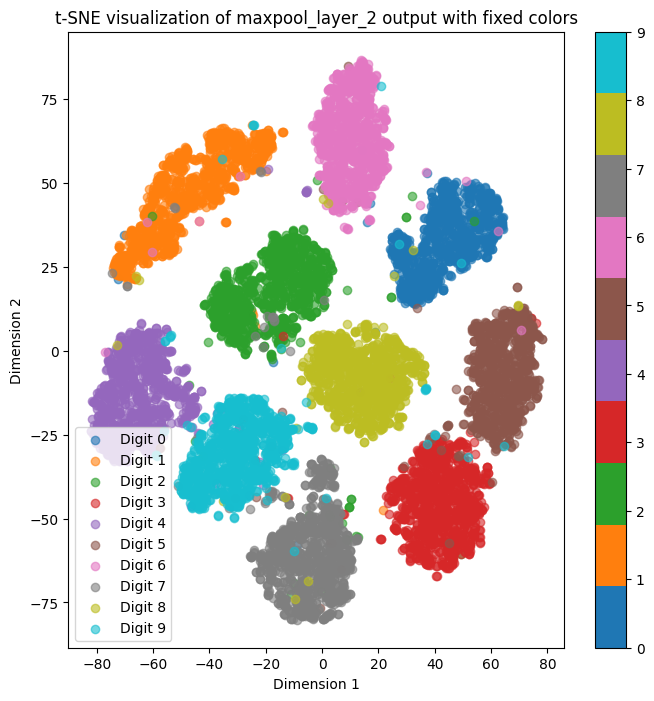

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


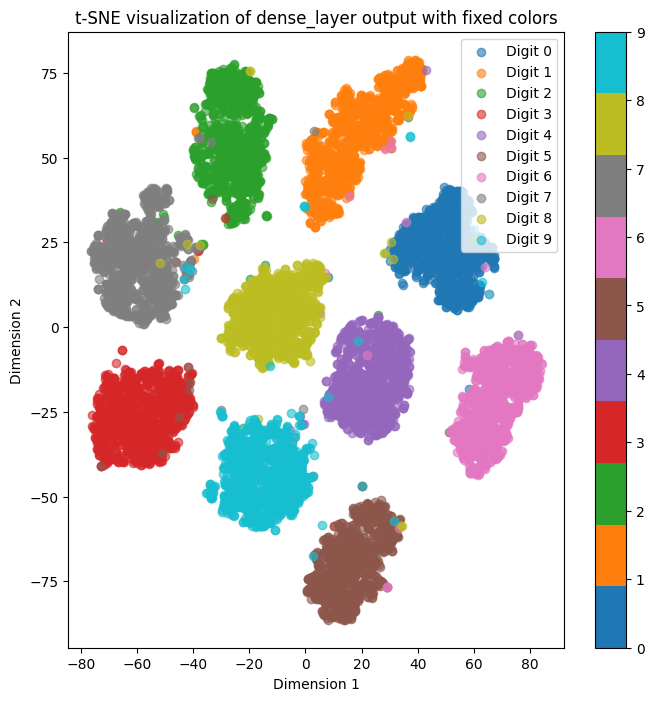

In [ ]:
# 4. Extract intermediate representations from each layer
layer_names = ['conv_layer_1', 'maxpool_layer_1', 'conv_layer_2', 'maxpool_layer_2', 'dense_layer']

# Loop through each layer and visualize with t-SNE
for layer_name in layer_names:
    # Create a model that outputs the representation of the current layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Get the output from the intermediate layer (for test set)
    intermediate_output = intermediate_layer_model.predict(x_test)

    # For convolutional layers, flatten the output to 2D for t-SNE (required for visualization)
    if len(intermediate_output.shape) > 2:
        intermediate_output = intermediate_output.reshape(intermediate_output.shape[0], -1)

    # 5. Apply t-SNE for dimensionality reduction to 2D space
    tsne = TSNE(n_components=2, random_state=42)
    x_test_tsne = tsne.fit_transform(intermediate_output)

    # 6. Visualize the t-SNE result for the current layer with fixed color map
    plt.figure(figsize=(8, 8))
    for i in range(10):  # Loop through each digit (0-9)
        indices = np.argmax(y_test, axis=1) == i  # Find indices for digit 'i'
        plt.scatter(x_test_tsne[indices, 0], x_test_tsne[indices, 1],
                    color=color_map[i], label=f'Digit {i}', alpha=0.6)

    # Use matplotlib.cm.ScalarMappable to fix the colorbar issue
    sm = cm.ScalarMappable(cmap='tab10', norm=norm)
    sm.set_array([])  # ScalarMappable expects an array, but it's not needed here

    # Get the current axes (plt.gca()) and pass it to the colorbar function
    plt.colorbar(sm, ticks=range(10), ax=plt.gca())

    plt.title(f't-SNE visualization of {layer_name} output with fixed colors')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()